# Project ML / DSA : Sentiment Analysis dengan CV ANN Classifier

### Read Feature (Text) and Target (Rating)

In [4]:
from sklearn.datasets import load_files
import numpy as np

reviews = load_files("dataset", encoding="ISO-8859-1")
texts, rating = reviews.data, reviews.target

### Custom Test-Train Text Split Method

In [5]:
from sklearn.feature_extraction.text import CountVectorizer
# from sklearn.decomposition import PCA
# from sklearn.preprocessing import StandardScaler
from nltk.tokenize import RegexpTokenizer
from sklearn.model_selection import train_test_split as tts

def train_test_text_split(X, y, test_size=0.25):
    # normal split
    text_train, text_test, y_train, y_test = tts(texts, rating, test_size=test_size)
    
    # define tokenizer
    token = RegexpTokenizer(r'[a-zA-Z0-9]+')

    # define the vectorizer
    vect = CountVectorizer(min_df=5, lowercase=True,
                           stop_words='english',
                           ngram_range = (1,1),
                           tokenizer = token.tokenize)
    
    # vectorize text
    X_train = vect.fit(text_train).transform(text_train).todense()
    X_test = vect.transform(text_test).todense()
    
    return X_train, X_test, y_train, y_test
    

### Vectorizing Text to get the trainable features

In [32]:
from sklearn.feature_extraction.text import CountVectorizer
# from sklearn.decomposition import PCA
# from sklearn.preprocessing import StandardScaler
from nltk.tokenize import RegexpTokenizer

# define tokenizer
token = RegexpTokenizer(r'[a-zA-Z0-9]+')

# define the vectorizer
vect = CountVectorizer(min_df=5, lowercase=True,
                       stop_words='english',
                       ngram_range = (1,1),
                       tokenizer = token.tokenize)

# define the PCA
# pca = PCA(n_components=50)

# define the scaler
# scaler = StandardScaler()

# transform text into trainable vectors

X_train = vect.fit(text_train).transform(text_train).todense()
X_test = vect.transform(text_test).todense()
# X_train_pca = pca.fit(X_train).transform(X_train)
# X_test_pca = pca.transform(X_test)

### Building The ANN Classifier

In [6]:
import keras
from keras.models import Sequential
from keras.layers import Dense, Dropout
from keras.utils import to_categorical
import numpy as np

def create_ann_clf(feature_count, num_classes):
    classifier = Sequential()
    hidden_units = (feature_count + 1) // 2
    classifier.add(Dense(output_dim = hidden_units, init = 'uniform', 
                         activation = 'relu', input_dim = feature_count))
    classifier.add(Dropout(0.5))
    classifier.add(Dense(output_dim = hidden_units, activation = 'relu'))
    classifier.add(Dropout(0.5))
    classifier.add(Dense(output_dim = num_classes, init = 'uniform', 
                         activation = 'softmax'))
    classifier.compile(optimizer = 'adam', loss = 'categorical_crossentropy', 
                       metrics = ['accuracy'])
    return classifier


Using TensorFlow backend.


### Create the Hybrind ANN-NB class

In [9]:
from sklearn.naive_bayes import MultinomialNB

class HybridANNBayesClassifier:
    
    def __init__(self):
        self.bayes_model = MultinomialNB()
        
    def get_x_with_dk(self, X):
        domain_knowledge = self.ann_model.predict(X)
        return np.concatenate([np.array(X),np.matrix(np.argmax(domain_knowledge, axis=1)).transpose()], axis=1)
    
    def fit(self, X, y, cons_len=0):
        # cons len is used when we want to count the learning curve
        if cons_len:
            self.ann_model = create_ann_clf(X.shape[1], cons_len)
        else:
            self.ann_model = create_ann_clf(X.shape[1], len(set(y)))
        self.ann_model.fit(X, to_categorical(y))
        self.bayes_model.fit(self.get_x_with_dk(X), y)
        
    def score(self, X, y):
        return self.bayes_model.score(self.get_x_with_dk(X), y)
    
    def predict(self, X, y):
        return self.bayes_model.predict(self.get_x_with_dk(X))        

### Comparison

Beside Baseline (Dummy Classifier) and Hybrid ANN-NB, there are 3 other algorithm that'll be used for comparison. They are Logistic Regression, MLPClassifier (ANN), and Naive Bayes.

#### Performance Report Method

In [35]:
import numpy as np
def report_performance(report):
    for model, scores in report.items():
        print("Model: ", model)
        print("Max: ", np.max(scores))
        print("Min: ", np.min(scores))
        print("Avg: ", np.mean(scores))
        print()

#### Model Performance Measuring Method (complete with cross validation)

In [22]:
def compare_performances(models, X, y, cv=3):
    scores = {}
    
    # initiate scores
    for name in models:
        scores[name] = []
        
    # cross-validate as demanded
    for i in range(cv):
        
        # all models use the same train-test data per cv
        X_train, X_test, y_train, y_test = train_test_text_split(X, y, test_size=0.25)
        
        # iterate all models
        for name, model in models.items():
            model.fit(X_train,y_train)
            scores[name].append(model.score(X_test, y_test))
    return scores

#### Defining Models

Aside from Hybrid ANN-NB model, all other model are used from sklearn library

In [20]:
from sklearn.dummy import DummyClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.neural_network import MLPClassifier

models = {'Baseline': DummyClassifier(),
          'HybridANN-NB': HybridANNBayesClassifier(),
          'ANN': MLPClassifier(),
          'Naive Bayes': MultinomialNB(),
          'Logistic Regression': LogisticRegression()
         }

#### Measure all models

In [39]:
report = compare_performances(models, texts, rating, cv=10)

C:\Users\PS15S\Anaconda3\lib\site-packages\ipykernel_launcher.py:12: UserWarning: Update your `Dense` call to the Keras 2 API: `Dense(activation="relu", input_dim=1328, units=664, kernel_initializer="uniform")`
  if sys.path[0] == '':
C:\Users\PS15S\Anaconda3\lib\site-packages\ipykernel_launcher.py:14: UserWarning: Update your `Dense` call to the Keras 2 API: `Dense(activation="relu", units=664)`
  
C:\Users\PS15S\Anaconda3\lib\site-packages\ipykernel_launcher.py:17: UserWarning: Update your `Dense` call to the Keras 2 API: `Dense(activation="softmax", units=5, kernel_initializer="uniform")`


Epoch 1/1
405/405 [==============================] - 4s 9ms/step - loss: 1.6106 - acc: 0.2568


C:\Users\PS15S\Anaconda3\lib\site-packages\sklearn\neural_network\multilayer_perceptron.py:562: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
C:\Users\PS15S\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\Users\PS15S\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:460: FutureWarning: Default multi_class will be changed to 'auto' in 0.22. Specify the multi_class option to silence this warning.
  "this warning.", FutureWarning)
C:\Users\PS15S\Anaconda3\lib\site-packages\ipykernel_launcher.py:12: UserWarning: Update your `Dense` call to the Keras 2 API: `Dense(activation="relu", input_dim=1366, units=683, kernel_initializer="uniform")`
  if sys.path[0] == '':
C:\Users\PS15S\Anaconda3\lib\site-packages\ipykernel_launcher.py:

Epoch 1/1
405/405 [==============================] - 4s 11ms/step - loss: 1.6257 - acc: 0.2494


C:\Users\PS15S\Anaconda3\lib\site-packages\sklearn\neural_network\multilayer_perceptron.py:562: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
C:\Users\PS15S\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\Users\PS15S\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:460: FutureWarning: Default multi_class will be changed to 'auto' in 0.22. Specify the multi_class option to silence this warning.
  "this warning.", FutureWarning)
C:\Users\PS15S\Anaconda3\lib\site-packages\ipykernel_launcher.py:12: UserWarning: Update your `Dense` call to the Keras 2 API: `Dense(activation="relu", input_dim=1324, units=662, kernel_initializer="uniform")`
  if sys.path[0] == '':
C:\Users\PS15S\Anaconda3\lib\site-packages\ipykernel_launcher.py:

Epoch 1/1
405/405 [==============================] - 4s 11ms/step - loss: 1.6261 - acc: 0.2543


C:\Users\PS15S\Anaconda3\lib\site-packages\sklearn\neural_network\multilayer_perceptron.py:562: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
C:\Users\PS15S\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\Users\PS15S\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:460: FutureWarning: Default multi_class will be changed to 'auto' in 0.22. Specify the multi_class option to silence this warning.
  "this warning.", FutureWarning)
C:\Users\PS15S\Anaconda3\lib\site-packages\ipykernel_launcher.py:12: UserWarning: Update your `Dense` call to the Keras 2 API: `Dense(activation="relu", input_dim=1333, units=667, kernel_initializer="uniform")`
  if sys.path[0] == '':
C:\Users\PS15S\Anaconda3\lib\site-packages\ipykernel_launcher.py:

Epoch 1/1
405/405 [==============================] - 4s 10ms/step - loss: 1.6375 - acc: 0.2519


C:\Users\PS15S\Anaconda3\lib\site-packages\sklearn\neural_network\multilayer_perceptron.py:562: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
C:\Users\PS15S\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\Users\PS15S\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:460: FutureWarning: Default multi_class will be changed to 'auto' in 0.22. Specify the multi_class option to silence this warning.
  "this warning.", FutureWarning)
C:\Users\PS15S\Anaconda3\lib\site-packages\ipykernel_launcher.py:12: UserWarning: Update your `Dense` call to the Keras 2 API: `Dense(activation="relu", input_dim=1357, units=679, kernel_initializer="uniform")`
  if sys.path[0] == '':
C:\Users\PS15S\Anaconda3\lib\site-packages\ipykernel_launcher.py:

Epoch 1/1
405/405 [==============================] - 4s 10ms/step - loss: 1.6398 - acc: 0.2469


C:\Users\PS15S\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\Users\PS15S\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:460: FutureWarning: Default multi_class will be changed to 'auto' in 0.22. Specify the multi_class option to silence this warning.
  "this warning.", FutureWarning)
C:\Users\PS15S\Anaconda3\lib\site-packages\ipykernel_launcher.py:12: UserWarning: Update your `Dense` call to the Keras 2 API: `Dense(activation="relu", input_dim=1311, units=656, kernel_initializer="uniform")`
  if sys.path[0] == '':
C:\Users\PS15S\Anaconda3\lib\site-packages\ipykernel_launcher.py:14: UserWarning: Update your `Dense` call to the Keras 2 API: `Dense(activation="relu", units=656)`
  
C:\Users\PS15S\Anaconda3\lib\site-packages\ipykernel_launcher.py:17: UserWarning: Update your `Dense` call to the Keras 2 API: `Dense(activation="soft

Epoch 1/1
405/405 [==============================] - 4s 10ms/step - loss: 1.6345 - acc: 0.2395


C:\Users\PS15S\Anaconda3\lib\site-packages\sklearn\neural_network\multilayer_perceptron.py:562: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
C:\Users\PS15S\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\Users\PS15S\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:460: FutureWarning: Default multi_class will be changed to 'auto' in 0.22. Specify the multi_class option to silence this warning.
  "this warning.", FutureWarning)
C:\Users\PS15S\Anaconda3\lib\site-packages\ipykernel_launcher.py:12: UserWarning: Update your `Dense` call to the Keras 2 API: `Dense(activation="relu", input_dim=1341, units=671, kernel_initializer="uniform")`
  if sys.path[0] == '':
C:\Users\PS15S\Anaconda3\lib\site-packages\ipykernel_launcher.py:

Epoch 1/1
405/405 [==============================] - 4s 11ms/step - loss: 1.6278 - acc: 0.2667


C:\Users\PS15S\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\Users\PS15S\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:460: FutureWarning: Default multi_class will be changed to 'auto' in 0.22. Specify the multi_class option to silence this warning.
  "this warning.", FutureWarning)
C:\Users\PS15S\Anaconda3\lib\site-packages\ipykernel_launcher.py:12: UserWarning: Update your `Dense` call to the Keras 2 API: `Dense(activation="relu", input_dim=1337, units=669, kernel_initializer="uniform")`
  if sys.path[0] == '':
C:\Users\PS15S\Anaconda3\lib\site-packages\ipykernel_launcher.py:14: UserWarning: Update your `Dense` call to the Keras 2 API: `Dense(activation="relu", units=669)`
  
C:\Users\PS15S\Anaconda3\lib\site-packages\ipykernel_launcher.py:17: UserWarning: Update your `Dense` call to the Keras 2 API: `Dense(activation="soft

Epoch 1/1
405/405 [==============================] - 4s 10ms/step - loss: 1.5964 - acc: 0.2938


C:\Users\PS15S\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\Users\PS15S\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:460: FutureWarning: Default multi_class will be changed to 'auto' in 0.22. Specify the multi_class option to silence this warning.
  "this warning.", FutureWarning)
C:\Users\PS15S\Anaconda3\lib\site-packages\ipykernel_launcher.py:12: UserWarning: Update your `Dense` call to the Keras 2 API: `Dense(activation="relu", input_dim=1336, units=668, kernel_initializer="uniform")`
  if sys.path[0] == '':
C:\Users\PS15S\Anaconda3\lib\site-packages\ipykernel_launcher.py:14: UserWarning: Update your `Dense` call to the Keras 2 API: `Dense(activation="relu", units=668)`
  
C:\Users\PS15S\Anaconda3\lib\site-packages\ipykernel_launcher.py:17: UserWarning: Update your `Dense` call to the Keras 2 API: `Dense(activation="soft

Epoch 1/1
405/405 [==============================] - 4s 10ms/step - loss: 1.6136 - acc: 0.2593


C:\Users\PS15S\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\Users\PS15S\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:460: FutureWarning: Default multi_class will be changed to 'auto' in 0.22. Specify the multi_class option to silence this warning.
  "this warning.", FutureWarning)
C:\Users\PS15S\Anaconda3\lib\site-packages\ipykernel_launcher.py:12: UserWarning: Update your `Dense` call to the Keras 2 API: `Dense(activation="relu", input_dim=1330, units=665, kernel_initializer="uniform")`
  if sys.path[0] == '':
C:\Users\PS15S\Anaconda3\lib\site-packages\ipykernel_launcher.py:14: UserWarning: Update your `Dense` call to the Keras 2 API: `Dense(activation="relu", units=665)`
  
C:\Users\PS15S\Anaconda3\lib\site-packages\ipykernel_launcher.py:17: UserWarning: Update your `Dense` call to the Keras 2 API: `Dense(activation="soft

Epoch 1/1
405/405 [==============================] - 5s 11ms/step - loss: 1.6048 - acc: 0.2049


C:\Users\PS15S\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\Users\PS15S\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:460: FutureWarning: Default multi_class will be changed to 'auto' in 0.22. Specify the multi_class option to silence this warning.
  "this warning.", FutureWarning)


#### Performance Report

In [40]:
report_performance(report)

Model:  Baseline
Max:  0.2222222222222222
Min:  0.15555555555555556
Avg:  0.20296296296296296

Model:  HybridANN-NB
Max:  0.4222222222222222
Min:  0.32592592592592595
Avg:  0.37037037037037035

Model:  ANN
Max:  0.4
Min:  0.28888888888888886
Avg:  0.3562962962962963

Model:  Naive Bayes
Max:  0.4148148148148148
Min:  0.28888888888888886
Avg:  0.35333333333333333

Model:  Logistic Regression
Max:  0.4222222222222222
Min:  0.362962962962963
Avg:  0.39481481481481484



### Learning Curve

DISCLAIMER : This is not my original code
    
source : https://gist.github.com/adrialuzllompart/c916c4ce3782a98ab5c92fe82ce0d293#file-plot_learning_curves-py

In [30]:
from matplotlib import pyplot as plt
from matplotlib.ticker import FuncFormatter

def plot_learning_curves(estimator, X_train, y_train, X_val, y_val,
                         suptitle='', title='', xlabel='', ylabel='', baseline=DummyClassifier()):
    """
    Plots learning curves for a given estimator.
    Parameters
    ----------
    estimator : sklearn estimator
    X_train : list
        training set (features)
    y_train : list
        training set (response)
    X_val : list
        validation set (features)
    y_val : list
        validation set (response)
    suptitle : str
        Chart suptitle
    title: str
        Chart title
    xlabel: str
        Label for the X axis
    ylabel: str
        Label for the y axis
    Returns
    -------
    Plot of learning curves
    """
    
    # create lists to store train and validation scores
    train_score = []
    val_score = []
    base_score = []

    # create ten incremental training set sizes
    training_set_sizes = np.linspace(5, len(X_train), 30, dtype='int')

    # for each one of those training set sizes
    for i in training_set_sizes:
        # fit the model only using that many training examples
        estimator.fit(X_train[0:i, :], y_train[0:i], len(set(y_test)))
        baseline.fit(X_train[0:i, :], y_train[0:i])
        # calculate the training accuracy only using those training examples
        train_accuracy = estimator.score(X_train[0:i, :], y_train[0:i])
        # calculate the validation accuracy using the whole validation set
        val_accuracy = estimator.score(X_val,y_val)
        # calculate the baseline accuracy using the whole validation set
        base_accuracy = baseline.score(X_val,y_val)
        # store the scores in their respective lists
        train_score.append(train_accuracy)
        val_score.append(val_accuracy)
        base_score.append(base_accuracy)
        
    # plot learning curves
    fig, ax = plt.subplots(figsize=(14, 9))
    ax.plot(training_set_sizes, train_score, c='gold')
    ax.plot(training_set_sizes, val_score, c='green')
    ax.plot(training_set_sizes, base_score, c='steelblue')

    # format the chart to make it look nice
    fig.suptitle(suptitle, fontweight='bold', fontsize='20')
    ax.set_title(title, size=20)
    ax.set_xlabel(xlabel, size=16)
    ax.set_ylabel(ylabel, size=16)
    ax.legend(['training score', 'testing score', 'baseline score'], fontsize=16)
    ax.tick_params(axis='both', labelsize=12)
    ax.set_ylim(0, 1)

    def percentages(x, pos):
        """The two args are the value and tick position"""
        if x < 1:
            return '{:1.0f}'.format(x*100)
        return '{:1.0f}%'.format(x*100)

    def numbers(x, pos):
        """The two args are the value and tick position"""
        if x >= 1000:
            return '{:1,.0f}'.format(x)
        return '{:1.0f}'.format(x)

    y_formatter = FuncFormatter(percentages)
    ax.yaxis.set_major_formatter(y_formatter)

    x_formatter = FuncFormatter(numbers)
    ax.xaxis.set_major_formatter(x_formatter)

C:\Users\PS15S\Anaconda3\lib\site-packages\ipykernel_launcher.py:12: UserWarning: Update your `Dense` call to the Keras 2 API: `Dense(activation="relu", input_dim=1303, units=652, kernel_initializer="uniform")`
  if sys.path[0] == '':
C:\Users\PS15S\Anaconda3\lib\site-packages\ipykernel_launcher.py:14: UserWarning: Update your `Dense` call to the Keras 2 API: `Dense(activation="relu", units=652)`
  
C:\Users\PS15S\Anaconda3\lib\site-packages\ipykernel_launcher.py:17: UserWarning: Update your `Dense` call to the Keras 2 API: `Dense(activation="softmax", units=5, kernel_initializer="uniform")`


Epoch 1/1
5/5 [==============================] - 3s 696ms/step - loss: 1.6429 - acc: 0.0000e+00


C:\Users\PS15S\Anaconda3\lib\site-packages\ipykernel_launcher.py:12: UserWarning: Update your `Dense` call to the Keras 2 API: `Dense(activation="relu", input_dim=1303, units=652, kernel_initializer="uniform")`
  if sys.path[0] == '':
C:\Users\PS15S\Anaconda3\lib\site-packages\ipykernel_launcher.py:14: UserWarning: Update your `Dense` call to the Keras 2 API: `Dense(activation="relu", units=652)`
  
C:\Users\PS15S\Anaconda3\lib\site-packages\ipykernel_launcher.py:17: UserWarning: Update your `Dense` call to the Keras 2 API: `Dense(activation="softmax", units=5, kernel_initializer="uniform")`


Epoch 1/1
18/18 [==============================] - 4s 230ms/step - loss: 1.6090 - acc: 0.1667


C:\Users\PS15S\Anaconda3\lib\site-packages\ipykernel_launcher.py:12: UserWarning: Update your `Dense` call to the Keras 2 API: `Dense(activation="relu", input_dim=1303, units=652, kernel_initializer="uniform")`
  if sys.path[0] == '':
C:\Users\PS15S\Anaconda3\lib\site-packages\ipykernel_launcher.py:14: UserWarning: Update your `Dense` call to the Keras 2 API: `Dense(activation="relu", units=652)`
  
C:\Users\PS15S\Anaconda3\lib\site-packages\ipykernel_launcher.py:17: UserWarning: Update your `Dense` call to the Keras 2 API: `Dense(activation="softmax", units=5, kernel_initializer="uniform")`


Epoch 1/1
32/32 [==============================] - 4s 133ms/step - loss: 1.6262 - acc: 0.0938


C:\Users\PS15S\Anaconda3\lib\site-packages\ipykernel_launcher.py:12: UserWarning: Update your `Dense` call to the Keras 2 API: `Dense(activation="relu", input_dim=1303, units=652, kernel_initializer="uniform")`
  if sys.path[0] == '':
C:\Users\PS15S\Anaconda3\lib\site-packages\ipykernel_launcher.py:14: UserWarning: Update your `Dense` call to the Keras 2 API: `Dense(activation="relu", units=652)`
  
C:\Users\PS15S\Anaconda3\lib\site-packages\ipykernel_launcher.py:17: UserWarning: Update your `Dense` call to the Keras 2 API: `Dense(activation="softmax", units=5, kernel_initializer="uniform")`


Epoch 1/1
46/46 [==============================] - 4s 90ms/step - loss: 1.6346 - acc: 0.1522


C:\Users\PS15S\Anaconda3\lib\site-packages\ipykernel_launcher.py:12: UserWarning: Update your `Dense` call to the Keras 2 API: `Dense(activation="relu", input_dim=1303, units=652, kernel_initializer="uniform")`
  if sys.path[0] == '':
C:\Users\PS15S\Anaconda3\lib\site-packages\ipykernel_launcher.py:14: UserWarning: Update your `Dense` call to the Keras 2 API: `Dense(activation="relu", units=652)`
  
C:\Users\PS15S\Anaconda3\lib\site-packages\ipykernel_launcher.py:17: UserWarning: Update your `Dense` call to the Keras 2 API: `Dense(activation="softmax", units=5, kernel_initializer="uniform")`


Epoch 1/1
60/60 [==============================] - 4s 74ms/step - loss: 1.6385 - acc: 0.2500


C:\Users\PS15S\Anaconda3\lib\site-packages\ipykernel_launcher.py:12: UserWarning: Update your `Dense` call to the Keras 2 API: `Dense(activation="relu", input_dim=1303, units=652, kernel_initializer="uniform")`
  if sys.path[0] == '':
C:\Users\PS15S\Anaconda3\lib\site-packages\ipykernel_launcher.py:14: UserWarning: Update your `Dense` call to the Keras 2 API: `Dense(activation="relu", units=652)`
  
C:\Users\PS15S\Anaconda3\lib\site-packages\ipykernel_launcher.py:17: UserWarning: Update your `Dense` call to the Keras 2 API: `Dense(activation="softmax", units=5, kernel_initializer="uniform")`


Epoch 1/1
73/73 [==============================] - 4s 60ms/step - loss: 1.6598 - acc: 0.2055


C:\Users\PS15S\Anaconda3\lib\site-packages\ipykernel_launcher.py:12: UserWarning: Update your `Dense` call to the Keras 2 API: `Dense(activation="relu", input_dim=1303, units=652, kernel_initializer="uniform")`
  if sys.path[0] == '':
C:\Users\PS15S\Anaconda3\lib\site-packages\ipykernel_launcher.py:14: UserWarning: Update your `Dense` call to the Keras 2 API: `Dense(activation="relu", units=652)`
  
C:\Users\PS15S\Anaconda3\lib\site-packages\ipykernel_launcher.py:17: UserWarning: Update your `Dense` call to the Keras 2 API: `Dense(activation="softmax", units=5, kernel_initializer="uniform")`


Epoch 1/1
87/87 [==============================] - 4s 51ms/step - loss: 1.5897 - acc: 0.2414


C:\Users\PS15S\Anaconda3\lib\site-packages\ipykernel_launcher.py:12: UserWarning: Update your `Dense` call to the Keras 2 API: `Dense(activation="relu", input_dim=1303, units=652, kernel_initializer="uniform")`
  if sys.path[0] == '':
C:\Users\PS15S\Anaconda3\lib\site-packages\ipykernel_launcher.py:14: UserWarning: Update your `Dense` call to the Keras 2 API: `Dense(activation="relu", units=652)`
  
C:\Users\PS15S\Anaconda3\lib\site-packages\ipykernel_launcher.py:17: UserWarning: Update your `Dense` call to the Keras 2 API: `Dense(activation="softmax", units=5, kernel_initializer="uniform")`


Epoch 1/1
101/101 [==============================] - 4s 44ms/step - loss: 1.5704 - acc: 0.2673


C:\Users\PS15S\Anaconda3\lib\site-packages\ipykernel_launcher.py:12: UserWarning: Update your `Dense` call to the Keras 2 API: `Dense(activation="relu", input_dim=1303, units=652, kernel_initializer="uniform")`
  if sys.path[0] == '':
C:\Users\PS15S\Anaconda3\lib\site-packages\ipykernel_launcher.py:14: UserWarning: Update your `Dense` call to the Keras 2 API: `Dense(activation="relu", units=652)`
  
C:\Users\PS15S\Anaconda3\lib\site-packages\ipykernel_launcher.py:17: UserWarning: Update your `Dense` call to the Keras 2 API: `Dense(activation="softmax", units=5, kernel_initializer="uniform")`


Epoch 1/1
115/115 [==============================] - 5s 39ms/step - loss: 1.5786 - acc: 0.2870


C:\Users\PS15S\Anaconda3\lib\site-packages\ipykernel_launcher.py:12: UserWarning: Update your `Dense` call to the Keras 2 API: `Dense(activation="relu", input_dim=1303, units=652, kernel_initializer="uniform")`
  if sys.path[0] == '':
C:\Users\PS15S\Anaconda3\lib\site-packages\ipykernel_launcher.py:14: UserWarning: Update your `Dense` call to the Keras 2 API: `Dense(activation="relu", units=652)`
  
C:\Users\PS15S\Anaconda3\lib\site-packages\ipykernel_launcher.py:17: UserWarning: Update your `Dense` call to the Keras 2 API: `Dense(activation="softmax", units=5, kernel_initializer="uniform")`


Epoch 1/1
129/129 [==============================] - 5s 37ms/step - loss: 1.6278 - acc: 0.1938


C:\Users\PS15S\Anaconda3\lib\site-packages\ipykernel_launcher.py:12: UserWarning: Update your `Dense` call to the Keras 2 API: `Dense(activation="relu", input_dim=1303, units=652, kernel_initializer="uniform")`
  if sys.path[0] == '':
C:\Users\PS15S\Anaconda3\lib\site-packages\ipykernel_launcher.py:14: UserWarning: Update your `Dense` call to the Keras 2 API: `Dense(activation="relu", units=652)`
  
C:\Users\PS15S\Anaconda3\lib\site-packages\ipykernel_launcher.py:17: UserWarning: Update your `Dense` call to the Keras 2 API: `Dense(activation="softmax", units=5, kernel_initializer="uniform")`


Epoch 1/1
142/142 [==============================] - 5s 34ms/step - loss: 1.6270 - acc: 0.2113


C:\Users\PS15S\Anaconda3\lib\site-packages\ipykernel_launcher.py:12: UserWarning: Update your `Dense` call to the Keras 2 API: `Dense(activation="relu", input_dim=1303, units=652, kernel_initializer="uniform")`
  if sys.path[0] == '':
C:\Users\PS15S\Anaconda3\lib\site-packages\ipykernel_launcher.py:14: UserWarning: Update your `Dense` call to the Keras 2 API: `Dense(activation="relu", units=652)`
  
C:\Users\PS15S\Anaconda3\lib\site-packages\ipykernel_launcher.py:17: UserWarning: Update your `Dense` call to the Keras 2 API: `Dense(activation="softmax", units=5, kernel_initializer="uniform")`


Epoch 1/1
156/156 [==============================] - 5s 31ms/step - loss: 1.6367 - acc: 0.1859


C:\Users\PS15S\Anaconda3\lib\site-packages\ipykernel_launcher.py:12: UserWarning: Update your `Dense` call to the Keras 2 API: `Dense(activation="relu", input_dim=1303, units=652, kernel_initializer="uniform")`
  if sys.path[0] == '':
C:\Users\PS15S\Anaconda3\lib\site-packages\ipykernel_launcher.py:14: UserWarning: Update your `Dense` call to the Keras 2 API: `Dense(activation="relu", units=652)`
  
C:\Users\PS15S\Anaconda3\lib\site-packages\ipykernel_launcher.py:17: UserWarning: Update your `Dense` call to the Keras 2 API: `Dense(activation="softmax", units=5, kernel_initializer="uniform")`


Epoch 1/1
170/170 [==============================] - 5s 29ms/step - loss: 1.5983 - acc: 0.1941


C:\Users\PS15S\Anaconda3\lib\site-packages\ipykernel_launcher.py:12: UserWarning: Update your `Dense` call to the Keras 2 API: `Dense(activation="relu", input_dim=1303, units=652, kernel_initializer="uniform")`
  if sys.path[0] == '':
C:\Users\PS15S\Anaconda3\lib\site-packages\ipykernel_launcher.py:14: UserWarning: Update your `Dense` call to the Keras 2 API: `Dense(activation="relu", units=652)`
  
C:\Users\PS15S\Anaconda3\lib\site-packages\ipykernel_launcher.py:17: UserWarning: Update your `Dense` call to the Keras 2 API: `Dense(activation="softmax", units=5, kernel_initializer="uniform")`


Epoch 1/1
184/184 [==============================] - 5s 28ms/step - loss: 1.6198 - acc: 0.1902


C:\Users\PS15S\Anaconda3\lib\site-packages\ipykernel_launcher.py:12: UserWarning: Update your `Dense` call to the Keras 2 API: `Dense(activation="relu", input_dim=1303, units=652, kernel_initializer="uniform")`
  if sys.path[0] == '':
C:\Users\PS15S\Anaconda3\lib\site-packages\ipykernel_launcher.py:14: UserWarning: Update your `Dense` call to the Keras 2 API: `Dense(activation="relu", units=652)`
  
C:\Users\PS15S\Anaconda3\lib\site-packages\ipykernel_launcher.py:17: UserWarning: Update your `Dense` call to the Keras 2 API: `Dense(activation="softmax", units=5, kernel_initializer="uniform")`


Epoch 1/1
198/198 [==============================] - 5s 27ms/step - loss: 1.6180 - acc: 0.2071


C:\Users\PS15S\Anaconda3\lib\site-packages\ipykernel_launcher.py:12: UserWarning: Update your `Dense` call to the Keras 2 API: `Dense(activation="relu", input_dim=1303, units=652, kernel_initializer="uniform")`
  if sys.path[0] == '':
C:\Users\PS15S\Anaconda3\lib\site-packages\ipykernel_launcher.py:14: UserWarning: Update your `Dense` call to the Keras 2 API: `Dense(activation="relu", units=652)`
  
C:\Users\PS15S\Anaconda3\lib\site-packages\ipykernel_launcher.py:17: UserWarning: Update your `Dense` call to the Keras 2 API: `Dense(activation="softmax", units=5, kernel_initializer="uniform")`


Epoch 1/1
211/211 [==============================] - 5s 25ms/step - loss: 1.6152 - acc: 0.1564


C:\Users\PS15S\Anaconda3\lib\site-packages\ipykernel_launcher.py:12: UserWarning: Update your `Dense` call to the Keras 2 API: `Dense(activation="relu", input_dim=1303, units=652, kernel_initializer="uniform")`
  if sys.path[0] == '':
C:\Users\PS15S\Anaconda3\lib\site-packages\ipykernel_launcher.py:14: UserWarning: Update your `Dense` call to the Keras 2 API: `Dense(activation="relu", units=652)`
  
C:\Users\PS15S\Anaconda3\lib\site-packages\ipykernel_launcher.py:17: UserWarning: Update your `Dense` call to the Keras 2 API: `Dense(activation="softmax", units=5, kernel_initializer="uniform")`


Epoch 1/1
225/225 [==============================] - 5s 23ms/step - loss: 1.6317 - acc: 0.2000


C:\Users\PS15S\Anaconda3\lib\site-packages\ipykernel_launcher.py:12: UserWarning: Update your `Dense` call to the Keras 2 API: `Dense(activation="relu", input_dim=1303, units=652, kernel_initializer="uniform")`
  if sys.path[0] == '':
C:\Users\PS15S\Anaconda3\lib\site-packages\ipykernel_launcher.py:14: UserWarning: Update your `Dense` call to the Keras 2 API: `Dense(activation="relu", units=652)`
  
C:\Users\PS15S\Anaconda3\lib\site-packages\ipykernel_launcher.py:17: UserWarning: Update your `Dense` call to the Keras 2 API: `Dense(activation="softmax", units=5, kernel_initializer="uniform")`


Epoch 1/1
239/239 [==============================] - 5s 23ms/step - loss: 1.6577 - acc: 0.2008


C:\Users\PS15S\Anaconda3\lib\site-packages\ipykernel_launcher.py:12: UserWarning: Update your `Dense` call to the Keras 2 API: `Dense(activation="relu", input_dim=1303, units=652, kernel_initializer="uniform")`
  if sys.path[0] == '':
C:\Users\PS15S\Anaconda3\lib\site-packages\ipykernel_launcher.py:14: UserWarning: Update your `Dense` call to the Keras 2 API: `Dense(activation="relu", units=652)`
  
C:\Users\PS15S\Anaconda3\lib\site-packages\ipykernel_launcher.py:17: UserWarning: Update your `Dense` call to the Keras 2 API: `Dense(activation="softmax", units=5, kernel_initializer="uniform")`


Epoch 1/1
253/253 [==============================] - 5s 21ms/step - loss: 1.6210 - acc: 0.2648


C:\Users\PS15S\Anaconda3\lib\site-packages\ipykernel_launcher.py:12: UserWarning: Update your `Dense` call to the Keras 2 API: `Dense(activation="relu", input_dim=1303, units=652, kernel_initializer="uniform")`
  if sys.path[0] == '':
C:\Users\PS15S\Anaconda3\lib\site-packages\ipykernel_launcher.py:14: UserWarning: Update your `Dense` call to the Keras 2 API: `Dense(activation="relu", units=652)`
  
C:\Users\PS15S\Anaconda3\lib\site-packages\ipykernel_launcher.py:17: UserWarning: Update your `Dense` call to the Keras 2 API: `Dense(activation="softmax", units=5, kernel_initializer="uniform")`


Epoch 1/1
267/267 [==============================] - 6s 21ms/step - loss: 1.6122 - acc: 0.1985


C:\Users\PS15S\Anaconda3\lib\site-packages\ipykernel_launcher.py:12: UserWarning: Update your `Dense` call to the Keras 2 API: `Dense(activation="relu", input_dim=1303, units=652, kernel_initializer="uniform")`
  if sys.path[0] == '':
C:\Users\PS15S\Anaconda3\lib\site-packages\ipykernel_launcher.py:14: UserWarning: Update your `Dense` call to the Keras 2 API: `Dense(activation="relu", units=652)`
  
C:\Users\PS15S\Anaconda3\lib\site-packages\ipykernel_launcher.py:17: UserWarning: Update your `Dense` call to the Keras 2 API: `Dense(activation="softmax", units=5, kernel_initializer="uniform")`


Epoch 1/1
280/280 [==============================] - 6s 21ms/step - loss: 1.6276 - acc: 0.2821


C:\Users\PS15S\Anaconda3\lib\site-packages\ipykernel_launcher.py:12: UserWarning: Update your `Dense` call to the Keras 2 API: `Dense(activation="relu", input_dim=1303, units=652, kernel_initializer="uniform")`
  if sys.path[0] == '':
C:\Users\PS15S\Anaconda3\lib\site-packages\ipykernel_launcher.py:14: UserWarning: Update your `Dense` call to the Keras 2 API: `Dense(activation="relu", units=652)`
  
C:\Users\PS15S\Anaconda3\lib\site-packages\ipykernel_launcher.py:17: UserWarning: Update your `Dense` call to the Keras 2 API: `Dense(activation="softmax", units=5, kernel_initializer="uniform")`


Epoch 1/1
294/294 [==============================] - 6s 20ms/step - loss: 1.6083 - acc: 0.2415


C:\Users\PS15S\Anaconda3\lib\site-packages\ipykernel_launcher.py:12: UserWarning: Update your `Dense` call to the Keras 2 API: `Dense(activation="relu", input_dim=1303, units=652, kernel_initializer="uniform")`
  if sys.path[0] == '':
C:\Users\PS15S\Anaconda3\lib\site-packages\ipykernel_launcher.py:14: UserWarning: Update your `Dense` call to the Keras 2 API: `Dense(activation="relu", units=652)`
  
C:\Users\PS15S\Anaconda3\lib\site-packages\ipykernel_launcher.py:17: UserWarning: Update your `Dense` call to the Keras 2 API: `Dense(activation="softmax", units=5, kernel_initializer="uniform")`


Epoch 1/1
308/308 [==============================] - 6s 19ms/step - loss: 1.6190 - acc: 0.2890


C:\Users\PS15S\Anaconda3\lib\site-packages\ipykernel_launcher.py:12: UserWarning: Update your `Dense` call to the Keras 2 API: `Dense(activation="relu", input_dim=1303, units=652, kernel_initializer="uniform")`
  if sys.path[0] == '':
C:\Users\PS15S\Anaconda3\lib\site-packages\ipykernel_launcher.py:14: UserWarning: Update your `Dense` call to the Keras 2 API: `Dense(activation="relu", units=652)`
  
C:\Users\PS15S\Anaconda3\lib\site-packages\ipykernel_launcher.py:17: UserWarning: Update your `Dense` call to the Keras 2 API: `Dense(activation="softmax", units=5, kernel_initializer="uniform")`


Epoch 1/1
322/322 [==============================] - 6s 19ms/step - loss: 1.6347 - acc: 0.2143


C:\Users\PS15S\Anaconda3\lib\site-packages\ipykernel_launcher.py:12: UserWarning: Update your `Dense` call to the Keras 2 API: `Dense(activation="relu", input_dim=1303, units=652, kernel_initializer="uniform")`
  if sys.path[0] == '':
C:\Users\PS15S\Anaconda3\lib\site-packages\ipykernel_launcher.py:14: UserWarning: Update your `Dense` call to the Keras 2 API: `Dense(activation="relu", units=652)`
  
C:\Users\PS15S\Anaconda3\lib\site-packages\ipykernel_launcher.py:17: UserWarning: Update your `Dense` call to the Keras 2 API: `Dense(activation="softmax", units=5, kernel_initializer="uniform")`


Epoch 1/1
336/336 [==============================] - 6s 18ms/step - loss: 1.6311 - acc: 0.2381


C:\Users\PS15S\Anaconda3\lib\site-packages\ipykernel_launcher.py:12: UserWarning: Update your `Dense` call to the Keras 2 API: `Dense(activation="relu", input_dim=1303, units=652, kernel_initializer="uniform")`
  if sys.path[0] == '':
C:\Users\PS15S\Anaconda3\lib\site-packages\ipykernel_launcher.py:14: UserWarning: Update your `Dense` call to the Keras 2 API: `Dense(activation="relu", units=652)`
  
C:\Users\PS15S\Anaconda3\lib\site-packages\ipykernel_launcher.py:17: UserWarning: Update your `Dense` call to the Keras 2 API: `Dense(activation="softmax", units=5, kernel_initializer="uniform")`


Epoch 1/1
349/349 [==============================] - 6s 18ms/step - loss: 1.6296 - acc: 0.2235


C:\Users\PS15S\Anaconda3\lib\site-packages\ipykernel_launcher.py:12: UserWarning: Update your `Dense` call to the Keras 2 API: `Dense(activation="relu", input_dim=1303, units=652, kernel_initializer="uniform")`
  if sys.path[0] == '':
C:\Users\PS15S\Anaconda3\lib\site-packages\ipykernel_launcher.py:14: UserWarning: Update your `Dense` call to the Keras 2 API: `Dense(activation="relu", units=652)`
  
C:\Users\PS15S\Anaconda3\lib\site-packages\ipykernel_launcher.py:17: UserWarning: Update your `Dense` call to the Keras 2 API: `Dense(activation="softmax", units=5, kernel_initializer="uniform")`


Epoch 1/1
363/363 [==============================] - 6s 17ms/step - loss: 1.6313 - acc: 0.2204


C:\Users\PS15S\Anaconda3\lib\site-packages\ipykernel_launcher.py:12: UserWarning: Update your `Dense` call to the Keras 2 API: `Dense(activation="relu", input_dim=1303, units=652, kernel_initializer="uniform")`
  if sys.path[0] == '':
C:\Users\PS15S\Anaconda3\lib\site-packages\ipykernel_launcher.py:14: UserWarning: Update your `Dense` call to the Keras 2 API: `Dense(activation="relu", units=652)`
  
C:\Users\PS15S\Anaconda3\lib\site-packages\ipykernel_launcher.py:17: UserWarning: Update your `Dense` call to the Keras 2 API: `Dense(activation="softmax", units=5, kernel_initializer="uniform")`


Epoch 1/1
377/377 [==============================] - 6s 17ms/step - loss: 1.6192 - acc: 0.2759


C:\Users\PS15S\Anaconda3\lib\site-packages\ipykernel_launcher.py:12: UserWarning: Update your `Dense` call to the Keras 2 API: `Dense(activation="relu", input_dim=1303, units=652, kernel_initializer="uniform")`
  if sys.path[0] == '':
C:\Users\PS15S\Anaconda3\lib\site-packages\ipykernel_launcher.py:14: UserWarning: Update your `Dense` call to the Keras 2 API: `Dense(activation="relu", units=652)`
  
C:\Users\PS15S\Anaconda3\lib\site-packages\ipykernel_launcher.py:17: UserWarning: Update your `Dense` call to the Keras 2 API: `Dense(activation="softmax", units=5, kernel_initializer="uniform")`


Epoch 1/1
391/391 [==============================] - 6s 17ms/step - loss: 1.6101 - acc: 0.2379


C:\Users\PS15S\Anaconda3\lib\site-packages\ipykernel_launcher.py:12: UserWarning: Update your `Dense` call to the Keras 2 API: `Dense(activation="relu", input_dim=1303, units=652, kernel_initializer="uniform")`
  if sys.path[0] == '':
C:\Users\PS15S\Anaconda3\lib\site-packages\ipykernel_launcher.py:14: UserWarning: Update your `Dense` call to the Keras 2 API: `Dense(activation="relu", units=652)`
  
C:\Users\PS15S\Anaconda3\lib\site-packages\ipykernel_launcher.py:17: UserWarning: Update your `Dense` call to the Keras 2 API: `Dense(activation="softmax", units=5, kernel_initializer="uniform")`


Epoch 1/1
405/405 [==============================] - 7s 16ms/step - loss: 1.6127 - acc: 0.2296


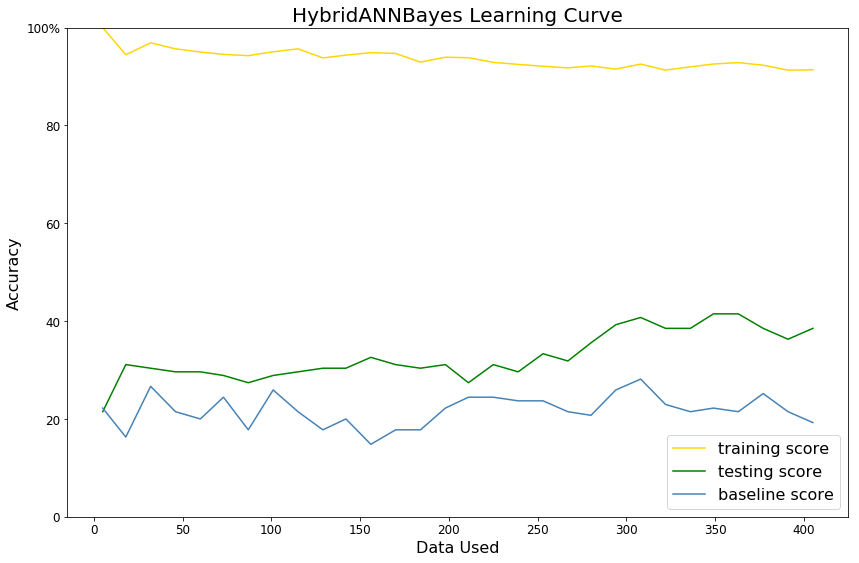

In [31]:
X_train, X_test, y_train, y_test = train_test_text_split(texts, rating, test_size=0.25)
hybrid_model = HybridANNBayesClassifier()

plot_learning_curves(hybrid_model, X_train, y_train, X_test, y_test,
                         suptitle='', title='HybridANNBayes Learning Curve', xlabel='Data Used', ylabel='Accuracy')